[[ 24.94003847+0.00000000e+00j  12.73268299+8.13973513e-15j
   -1.38095598+9.45384834e-15j ... -64.02389647+2.08327967e-14j
  -67.76356741-5.05150054e-15j -61.18058974-3.76113900e-14j]
 [-18.55666362-5.81663109e+01j -42.51586944-4.69129224e+01j
  -60.80795253-2.57480390e+01j ... -26.39439597+1.13082890e+02j
    6.86544434+1.23000456e+02j  41.4436393 +1.10055312e+02j]
 [-16.04755868+3.28279829e+01j -22.03971648-4.57977740e+01j
  -23.23089505-1.04141716e+02j ... -25.03391682-9.26527314e+01j
  -29.2936105 -4.09594873e+01j -31.3712619 +1.56986891e+01j]
 ...
 [ 24.73021466-5.66774723e+02j  34.94179045-3.31372917e+02j
   38.82924248-4.97842318e+01j ...   4.99619196+6.02396295e+02j
   -9.93322885+4.90736906e+02j -25.6299042 +2.81792021e+02j]
 [ 25.33720124-3.61633792e+02j  43.00958768-4.53711746e+02j
   51.93221654-4.47841562e+02j ... -30.76392977+2.66442187e+02j
  -58.45411318+4.29165358e+02j -74.0191717 +5.05315322e+02j]
 [ -6.4753501 +3.96245454e+01j  15.86720969-5.83358549e+01j
   37.7389

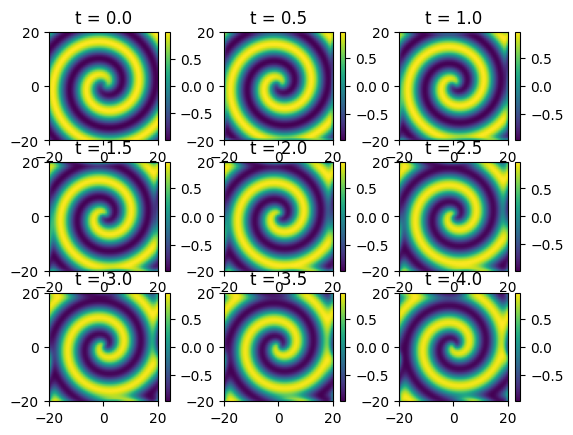

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

# Reaction-diffusion parameters
L = 20
n = 64
beta = 1
D1, D2 = 0.1, 0.1
tspan = (0, 4)
t_eval = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

#Spatial Domain
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

#Spectral k
kx = (2 * np.pi/Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = (2 * np.pi/Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

#calculate u and v
m = 1
u = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
ut = fft2(u)
vt = fft2(v)
uvt0 = np.hstack((ut.reshape(N), vt.reshape(N)))

#define pde
def spc_rhs(t, uvt):
    utc = uvt[0:N]
    vtc = uvt[N:]
    ut = utc.reshape(nx, ny)
    vt = vtc.reshape(nx, ny)
    u = ifft2(ut)
    v = ifft2(vt)

    A = u*u + v*v
    Lambda = 1-A
    Omega = -beta*A

    rhs_u = (-D1 * K * ut + fft2( Lambda*u - Omega*v)).reshape(N)
    rhs_v = (-D2 * K * vt + fft2( Omega*u + Lambda*v)).reshape(N)
    rhs = np.hstack([rhs_u, rhs_v])

    return rhs

uvtsol = solve_ivp(spc_rhs, [0,4], uvt0, t_eval=t_eval, args=(), method = 'RK45')
z = uvtsol.y
A1 = z

print(A1)

for j, t in enumerate(t_eval):
    u = np.real(ifft2(A1[0:nx*ny, j].reshape((nx, ny))))
    plt.subplot(3, 3, j+1)
    plt.imshow(u, extent=(-Lx, Lx, -Ly, Ly), origin="lower", cmap="viridis")
    plt.colorbar()
    plt.title(f"t = {t}")

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import kron
from numpy import *

# Function to compute Chebyshev differentiation matrix
def cheb(N):
    if N == 0:
        D = 0.; x = 1.
    else:
        n = arange(0, N + 1)
        x = cos(pi * n / N).reshape(N + 1, 1)
        c = (hstack(([2.], ones(N - 1), [2.])) * (-1) ** n).reshape(N + 1, 1)
        X = tile(x, (1, N + 1))
        dX = X - X.T
        D = dot(c, 1. / c.T) / (dX + eye(N + 1))
        D -= diag(sum(D.T, axis=0))
    return D, x.reshape(N + 1)

# parameters
N = 30
D,x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = np.dot(D, D)/100
y = x
N2 = (N + 1) * (N + 1)
I = np.eye(len(Dxx))
L = kron(I, Dxx) + kron(Dxx, I)

D1 = D2 = 0.1
beta = 1
tspan = (0, 4)
timesteps = np.arange(0, 4.5, 0.5)

X,Y = np.meshgrid(x,y)
X = X * (20/2)
Y = Y * (20/2)

#Compute u & v
m = 1
u=np.tanh(np.sqrt(X**2+Y**2)) * np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)))
v=np.tanh(np.sqrt(X**2+Y**2)) * np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)))
uv0 = np.hstack((u.reshape(N2), v.reshape(N2)))

# Define the reaction-diffusion PDE system
def RD(t, uv):
    u = uv[0:N2]
    v = uv[N2:]

    A2 = u**2 + v**2
    Lambda = 1 - A2
    Omega = -beta * A2

    rhs_u = D1 * np.dot(L, u) + Lambda * u - Omega * v
    rhs_v = D2 * np.dot(L, v) + Omega * u + Lambda * v

    return np.hstack([rhs_u, rhs_v])

uvsol = solve_ivp(RD,  tspan, uv0, t_eval=t_eval, args=(), method='RK45')
sol = uvsol.y
A2 = sol
print(A2)

[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]
